# Classifying Yelp Reviews (Classifying Sentiment of Restaurant Reviews, chapter 3) 

### Source: Chapter 3, Natural Language Processing with Pytorch. (2019). Delip Rao and Brian McMahan. O’Reilly: source code available on https://github.com/joosthub/PyTorchNLPBook

### PyTorch tutorial: refer to https://pytorch.org/tutorials/

## Imports

In [1]:
'''
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
use to prevent kernal crash due to re-initializing  libiomp5md.dll
'''
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
from argparse import Namespace
from collections import Counter
import json
# import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

## Data Vectorization classes

### The Vocabulary

In [3]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         # _token_to_idx: {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}
                                                  # _idx_to_token: {0:'<UNK>', 1:'apple', 2:'banana', ....., 10000:'zzz'}

        self._idx_to_token = {idx: token          
                              for token, idx in self._token_to_idx.items()} 
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
              
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:                   # if unk_token is defined, unknown words are handled
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

作用：

负责 管理词汇表，即 单词和索引的映射关系。
允许从 单词 → 索引 或 索引 → 单词 进行查找。
可以自动处理 未知单词（UNK Token），防止模型遇到未见过的单词时报错。

### The Vectorizer

In [4]:
from enum import Enum
class Vectorizer_Type(Enum):
    One_Hot = "one-hot"
    Term_Freq = "term-freq"
    TF_IDF = "tf-idf"

In [5]:
'''Followings are preprocessing functions'''

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions
from nltk.corpus import opinion_lexicon
import gensim
import gensim.downloader as api

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('opinion_lexicon')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()  ###better for Sentiment Analysis

def remove_special_char(text) :
    return re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

def case_folding(text) :
    return text.lower()

def expand_contractions(text):
    return contractions.fix(text)

def remove_stop_words(text) :
    tokens = word_tokenize(text)
    return  " ".join([word for word in tokens if word not in stop_words])

def wordnet_lemmatizer(text) : 
    ''' tokens = word_tokenize(text) should not tokenize again, directly split '''
    tokens = text.split()
    return  " ".join( [lemmatizer.lemmatize(word) for word in tokens ])

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [6]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab, vectorizer_type, tfidf_vectorizer=None, enable_opinion_lexicon=False, use_word_embedding=False):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers; {'negative':0, 'positive':1}
        """
        self.review_vocab = review_vocab     # {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}
        self.rating_vocab = rating_vocab     # {'negative':0, 'positive':1}

        ####newly added
        self.vectorize_type = vectorizer_type
        self.tfidf_vectorizer = tfidf_vectorizer
        self.enable_opinion_lexicon = enable_opinion_lexicon
        self.use_word_embedding = use_word_embedding

        if self.enable_opinion_lexicon :
            self.positive_words = set(opinion_lexicon.positive())
            self.negative_words = set(opinion_lexicon.negative())
        
        if self.use_word_embedding:
            self.glove_vectors = api.load("glove-wiki-gigaword-300")
            self.embedding_dim = 300
            print("GloVe model loaded!")

    def vectorize(self, review):
        """Create a collapsed one-hot vector for the review
        
        Args:
            review (str): the review 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding   
        """         
        if self.vectorize_type == Vectorizer_Type.TF_IDF:  # if use TF-IDF, directly return
            text_vector = self.tfidf_vectorizer.transform([review]).toarray().flatten() # i.e. [0.85, 0.47, ......, 0.0, 0.0] 
        elif self.vectorize_type == Vectorizer_Type.Term_Freq: ##if enable term_frequency
            text_vector = np.zeros(len(self.review_vocab), dtype=np.float32)
            for token in review.split(" "):
                if token not in string.punctuation:
                    index = self.review_vocab.lookup_token(token)
                    text_vector[index] += 1
        else:  # One-Hot Encoding
            text_vector = np.zeros(len(self.review_vocab), dtype=np.float32)
            for token in review.split(" "):
                if token not in string.punctuation:
                    text_vector[self.review_vocab.lookup_token(token)] = 1  # E.g., "Unfortunately, the frustration of being Dr. Go..." -> [0, 0, 1, 0, 1, ....., 0, 0]

        '''
        Word Embedding(GloVe)
        In sentiment analysis, glove is more suitable than word2vec.

        If the word embedding is flattened directly, the dimensions will be too large. if the length of words in sentence is 100, the dims will be 100 * 300 = 30000, cannot control the dims.
        hence, I decide to use word embedding as additional dims instead of acting directly on vectorization, which means not parallel to IF-IDF, one-hot and term-freq.
        after deciede to act as additional dims, the calculation use mean instead of others (such as max, weighting), because this is sentiment classification, the overall feeling may be more important
        '''
        if self.use_word_embedding:
            embedding_vector = self.word_embedding_vector(review)
            text_vector = np.concatenate((text_vector, embedding_vector))  # concatenate vector #add 300 dims

        '''
        To maintain the independence of different features to avoid information loss, 
        hence, decided to add two more dimensions instead of feature reweighting
        '''
        if self.enable_opinion_lexicon :  
            lexicon_features = self.sentiment_lexicon_features(review)
            combined_vector = np.concatenate((text_vector, lexicon_features)) #add 2 dims
            return combined_vector
        else:
            return text_vector
    
    '''for opinion lexicon'''
    def sentiment_lexicon_features(self, review):
        tokens = review.split()
        pos_count = sum(1 for word in tokens if word in self.positive_words)
        neg_count = sum(1 for word in tokens if word in self.negative_words)
        return np.array([pos_count, neg_count], dtype=np.float32)
    
    '''for word embedding'''
    def word_embedding_vector(self, review):
        tokens = review.split()
        word_vectors = []
        
        for word in tokens:
            if word in self.glove_vectors:
                word_vectors.append(self.glove_vectors[word])  # get word gloVe vector
        
        if len(word_vectors) == 0:
            return np.zeros(self.embedding_dim, dtype=np.float32)  # if not find, return 0
        else:
            return np.mean(word_vectors, axis=0)

    @classmethod
    def from_dataframe(cls, review_df, vectorizer_type, enable_opinion_lexicon, use_word_embedding, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            cls: class name, i.e. ReviewVectorizer
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)   # create an instance of Vocabulary class
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):  
            rating_vocab.add_token(rating)            # {'negative':0, 'positive':1}

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)          # {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}

        if vectorizer_type == Vectorizer_Type.TF_IDF :
            tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2))  # support unigram + bigram words
            tfidf_vectorizer.fit(review_df.review)
        else :
            tfidf_vectorizer = None

        return cls(review_vocab, rating_vocab, vectorizer_type, tfidf_vectorizer, enable_opinion_lexicon, use_word_embedding)

作用：

负责 将文本转换为数值向量，用于机器学习模型训练。
支持 词频 (Term Frequency) 统计 或 One-hot 编码。
该类主要负责 文本向量化，将文本转换为模型可以使用的 数值表示。

### The Dataset

In [7]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv, preprocessing_args, vectorizer_type, enable_opinion_lexicon, use_word_embedding, frequency_cutoff):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            cls: class name, i.e. ReviewDataset
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        # train_review_df = review_df[review_df.split=='train']
        train_review_df = review_df[review_df.split=='train'].copy() ### avoid too many alerts

        ##### APPLY PREPROCESSING HERE
        text_col = "review"
        if preprocessing_args.remove_special_char :
            train_review_df[text_col] = train_review_df[text_col].apply(remove_special_char)

        if preprocessing_args.case_folding :
            train_review_df[text_col] = train_review_df[text_col].apply(case_folding)

        if preprocessing_args.remove_punctuation :
            train_review_df[text_col] = train_review_df[text_col].apply(remove_punctuation)

        if preprocessing_args.expand_contractions :
            train_review_df[text_col] = train_review_df[text_col].apply(expand_contractions)
        
        if preprocessing_args.remove_stop_words :
            train_review_df[text_col] = train_review_df[text_col].apply(remove_stop_words)

        if preprocessing_args.wordnet_lemmatizer :
            train_review_df[text_col] = train_review_df[text_col].apply(wordnet_lemmatizer)


        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df, vectorizer_type, enable_opinion_lexicon, use_word_embedding, frequency_cutoff))
    
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,           #  e.g., { 'x_data': [0, 0, 1, 0, 1, ....., 0, 0],
                'y_target': rating_index}          #          'y_target': 0  }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  # the floor division // rounds the result down to the nearest whole number
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    # drop_last: set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. 
    # If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)
    # need to use sampler option for balanced data: 
    # https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)
    
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():  # name: x_data & y_target
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: ReviewClassifier

In [8]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features, hidden_dim, enable_second_hidden_layer, enable_drop_out, enable_batch_norm):
        """
        Args:
            num_features (int): the size of the input feature vector
            hidden_dim   (int): the size of hidden dimension
        """
        super(ReviewClassifier, self).__init__()
        self.dropout_rate = 0.5
        self.enable_second_hidden_layer = enable_second_hidden_layer
        self.enable_drop_out = enable_drop_out
        self.enable_batch_norm = enable_batch_norm

        self.fc1 = nn.Linear(in_features=num_features, out_features=hidden_dim)
        if enable_batch_norm:
            self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        if enable_drop_out :
            self.dropout1 = nn.Dropout(p=self.dropout_rate)

        if enable_second_hidden_layer :
            self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2) ###base on experience from lab assignment 1
            if enable_batch_norm:
                self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)
            if enable_drop_out :    
                self.dropout2 = nn.Dropout(p=self.dropout_rate)
            self.fc_final = nn.Linear(hidden_dim // 2, out_features=1)
        else :
            self.fc_final = nn.Linear(hidden_dim, out_features=1)

    def forward(self, x_in):
        """The forward pass of the classifier    
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be [batch, num_features]
        Returns:
            the resulting tensor. tensor.shape should be [batch]
        """
        intermediate = self.fc1(x_in)            # [batch, num_features] -> [batch, hidden_dim]
        if self.enable_batch_norm:
            intermediate = self.batch_norm1(intermediate)  
        intermediate = F.relu(intermediate)      # [batch, hidden_dim]
        if self.enable_drop_out :
            intermediate = self.dropout1(intermediate)

        if self.enable_second_hidden_layer:
            # Second hidden layer
            intermediate = self.fc2(intermediate)
            if self.enable_batch_norm:
                intermediate = self.batch_norm2(intermediate)
            intermediate = F.relu(intermediate)
            if self.enable_drop_out :
                intermediate = self.dropout2(intermediate)

        y_out = self.fc_final(intermediate)           # [batch, hidden_dim] -> [batch, out_features]
        return torch.sigmoid(y_out).squeeze()    # [batch, 1] -> [batch] (e.g., [0.3, 0.1, 0.7, 0.8, ..., 0.5])

## Training Routine

### Helper functions

In [9]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (y_pred>0.5).cpu().long()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()  # item() to get a Python number from a tensor containing a single value
    return n_correct / len(y_pred_indices) * 100

#### General utilities

In [10]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [11]:
'''newly added for preprocessing'''
preprocessing_args = Namespace(
    remove_special_char=False,
    case_folding=False,
    remove_punctuation=False,
    expand_contractions=False,
    remove_stop_words=False,
    wordnet_lemmatizer=False,
)

args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='data/yelp/reviews_with_splits_lite.csv',
    save_dir='model_storage/ch3/yelp/',
    # No Model hyper parameters
    hidden_dim=20,
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,


    ###Newly added
    
    ######for vectorizer
    vectorizer_type=Vectorizer_Type.One_Hot,
    enable_opinion_lexicon=False,
    use_word_embedding=False,

    ####for ReviewClassifier
    enable_second_hidden_layer=False,
    enable_drop_out=False,
    enable_batch_norm=False,

    ####for optimizer
    weight_decay=0, ##change to 0 to disable
)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs ; creat dirs if they don't exist
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch3/yelp/model.pth
Using CUDA: True


### Initializations

In [12]:
def init() :
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv, preprocessing_args, 
                                                            vectorizer_type=args.vectorizer_type,
                                                            enable_opinion_lexicon=args.enable_opinion_lexicon,
                                                            use_word_embedding=args.use_word_embedding,
                                                            frequency_cutoff=args.frequency_cutoff) 

    vectorizer = dataset.get_vectorizer()
    if args.vectorizer_type == Vectorizer_Type.TF_IDF :
        num_features = len(vectorizer.tfidf_vectorizer.vocabulary_)
        print(f'number of features => {num_features}')
        if args.enable_opinion_lexicon :
            num_features = num_features + 2
        if args.use_word_embedding :
            num_features = num_features + 300
        classifier = ReviewClassifier(num_features=num_features, hidden_dim=args.hidden_dim)
    else :
        num_features=len(vectorizer.review_vocab) ### original code
        print(f'number of features => {num_features}')
        if args.enable_opinion_lexicon :
            num_features = num_features + 2
        if args.use_word_embedding :
            num_features = num_features + 300
        classifier = ReviewClassifier(num_features=num_features, hidden_dim=args.hidden_dim,
                                    enable_second_hidden_layer=args.enable_second_hidden_layer,
                                    enable_batch_norm=args.enable_batch_norm,
                                    enable_drop_out=args.enable_drop_out)
    return dataset, vectorizer, classifier

In [13]:
#str(vectorizer.review_vocab), str(vectorizer.rating_vocab)

### Training loop

1. lr_scheduler.ReduceLROnPlateau(): Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.(https://pytorch.org/docs/stable/optim.html)
> - mode (str) – One of min, max. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; in max mode it will be reduced when the quantity monitored has stopped increasing. Default: ‘min’.<br>
>- factor (float) – Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.<br>
>- patience (int) – Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.

In [14]:
def train_model(dataset, classifier) :
    classifier = classifier.to(args.device)

    loss_func = nn.BCELoss()
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                    mode='min', factor=0.1,
                                                    patience=10) # Reduce learning rate when a metric has stopped improving.

    train_state = make_train_state(args)

    epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)  # progress bar

    dataset.set_split('train')
    train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

    dataset.set_split('val')
    val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
            running_loss = 0.0
            running_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:

                # --------------------------------------
                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. compute the output
                y_pred = classifier(x_in=batch_dict['x_data'].float())  # [batch, num_features] -> [batch]

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'].float())
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # step 4. use loss to produce gradients
                loss.backward()

                # step 5. use optimizer to take gradient step
                optimizer.step()
                # -----------------------------------------
                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                
                # update bar
                train_bar.set_postfix(loss=running_loss, 
                                    acc=running_acc, 
                                    epoch=epoch_index)
                train_bar.update()
            
            train_state['train_loss'].append(running_loss)  # train_loss for each epoch
            train_state['train_acc'].append(running_acc)    # train_acc for each epoch
            
            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred = classifier(x_in=batch_dict['x_data'].float())

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'].float())
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                
                val_bar.set_postfix(loss=running_loss, 
                                    acc=running_acc, 
                                    epoch=epoch_index)
                val_bar.update()

            train_state['val_loss'].append(running_loss)  # val_loss for each epoch
            train_state['val_acc'].append(running_acc)    # val_acc for each epoch

            train_state = update_train_state(args=args, model=classifier,
                                            train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])  # adjust learning rate

            if train_state['stop_early']:
                break

            train_bar.n = 0   # reset number of finished iterations
            val_bar.n = 0
            epoch_bar.update()
    except KeyboardInterrupt:
        print("Exiting loop")
    return train_state, loss_func

In [23]:
import matplotlib.pyplot as plt

def draw_loss_and_acc(train_state, title) :
    epochs = range(1, len(train_state['train_acc']) + 1)
    fig, ax1 = plt.subplots(1, 2, figsize=(15, 7))

    fig.suptitle(title, fontsize=16, fontweight="bold")

    ax1[0].plot(epochs, train_state['train_loss'], 'bo-', label='Training Loss')
    ax1[0].plot(epochs, train_state['val_loss'], 'r-', label='Validation Loss') 
    ax1[0].set_title('Training and Validation Loss')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].legend()

    ax1[1].plot(epochs, train_state['train_acc'], 'go-', label='Training Accuracy')
    ax1[1].plot(epochs, train_state['val_acc'], 'm-', label='Validation Accuracy') 
    ax1[1].set_title('Training and Validation Accuracy')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('Accuracy')
    ax1[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.tight_layout() 
    plt.show()

In [18]:
# compute the loss & accuracy on the test set using the best available model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

def check_test_data(dataset, classifier, train_state, loss_func) :
    classifier.load_state_dict(torch.load(train_state['model_filename'], weights_only=False))
    classifier = classifier.to(args.device)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    y_pred_list = []    # store predicted values for confusion matrix
    y_target_list = []  # ground truth value

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())
        
        # store predicted values and ground truth values for calculating confusion matrix
        y_pred_list.extend((y_pred>0.5).cpu().long().numpy())
        y_target_list.extend(batch_dict['y_target'].cpu().numpy())
        
        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc

    print("==================================dividing line==================================")
    print("Test loss: {:.3f}".format(train_state['test_loss']))
    print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

    rating_classes = []
    for i in range(len(dataset._vectorizer.rating_vocab)):
        rating_classes.append(dataset._vectorizer.rating_vocab.lookup_index(i))
    # print("==================================dividing line=======================")
    # print(rating_classes)

    cm = confusion_matrix(y_target_list, y_pred_list)
    cm_df = pd.DataFrame(cm.T, index=rating_classes, columns=rating_classes)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print("==================================dividing line==================================")
    print(cm_df)

    print("==================================dividing line==================================")
    print(classification_report(y_target_list, y_pred_list))

Loading dataset and creating vectorizer
number of features => 2256


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/39 [00:00<?, ?it/s]

split=val:   0%|          | 0/8 [00:00<?, ?it/s]

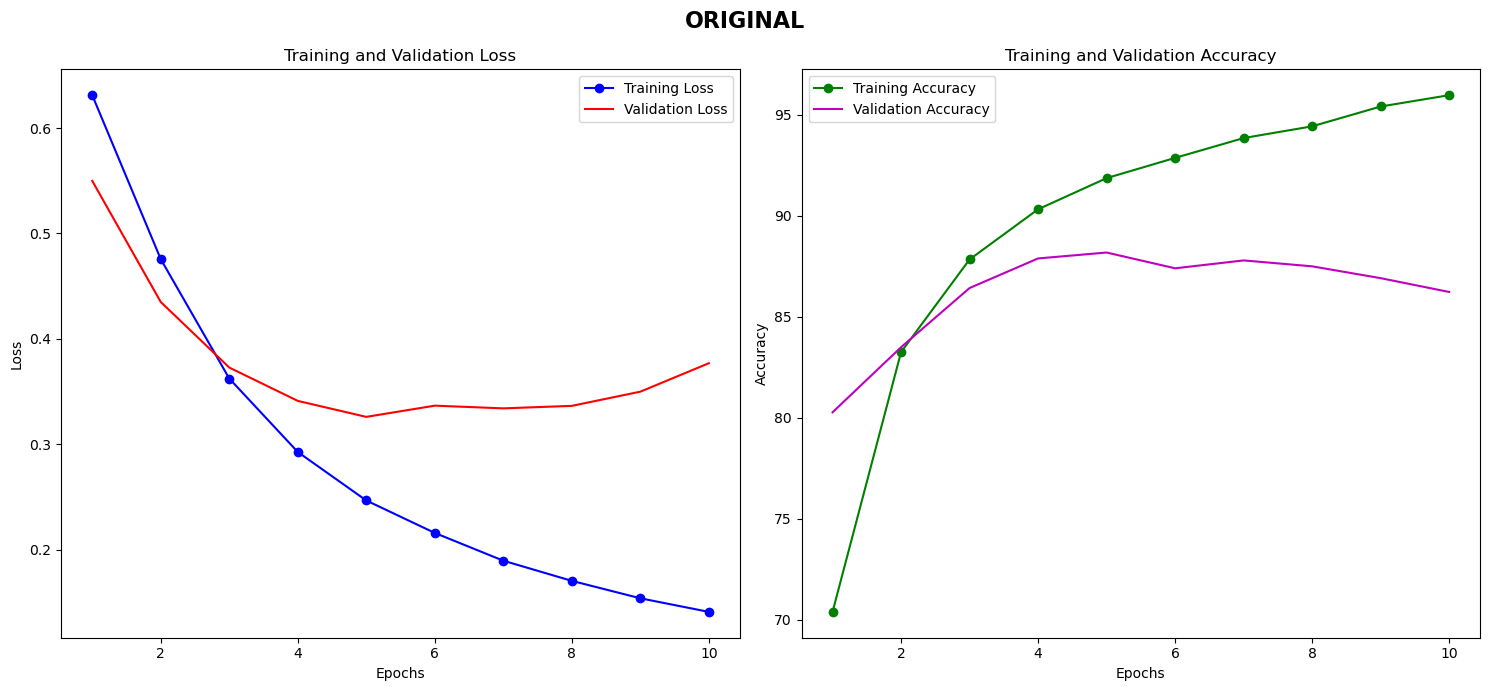

==================================dividing line==================================
Test loss: 0.341
Test Accuracy: 86.33
==================================dividing line==================================
True       negative  positive
Predicted                    
negative        446        68
positive         72       438
==================================dividing line==================================
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       518
           1       0.86      0.87      0.86       506

    accuracy                           0.86      1024
   macro avg       0.86      0.86      0.86      1024
weighted avg       0.86      0.86      0.86      1024



In [24]:
# ORIGINAL RESULT:

dataset, vectorizer, classifier = init()
train_state, loss_func = train_model(dataset=dataset, classifier=classifier)
draw_loss_and_acc(train_state, "ORIGINAL")
check_test_data(dataset, classifier, train_state, loss_func)

### End